# Hand digit classifier 
---
## Incremental network quantization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from skimage import io

### Importing MNIST dataset

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='../', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../", train=False, download=True, transform=transform)

train_set = [train_data[i] for i in range(5000)]
validation_set = [train_data[i] for i in range(50000, 60000)]

### Setting up data loaders

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Definig a VGG-7 inspired architecture model
---
Featuring 4 convolutional and 3 fully connected layers

In [2]:
class VGG7(nn.Module):
    def __init__(self):
        super(VGG7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding="same", stride=1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 3, padding="same", stride=1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding="same", stride=1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, padding="same", stride=1, bias=False)
        
        self.fc1 = nn.Linear(7*7*128, 512, bias=False)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.fc3 = nn.Linear(256, 10, bias=False)

    def forward(self, x): 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)  

        x = x.view(-1, 7*7*128)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  

        x = F.log_softmax(x, dim=1)  

        return x

### Shift Quantization operations

In [5]:
def getBounderyExponents(W, b):
    s = torch.max(torch.abs(W)).item()
    n1 = np.floor(np.log2(4*(s/3)))
    n2 = n1 + 1 - (2**(b - 1))/2
    return n1, n2

def getQuantizationMask(W, percentage, T):
    w = W.view(-1)
    t = T.view(-1)
    idx = t == 1

    numberOfWeights = w.size(dim=0)
    numberOfQWeights = int(percentage*numberOfWeights - t[idx].size(dim=0))

    t_aux = torch.Tensor(np.ones_like(T)).view(-1)
    w = w*(t_aux - t)
    w = torch.abs(w)
    sorted_w, indices_w = w.sort()
    t[indices_w[-numberOfQWeights:]] = 1
    
    return t.view(T.size())

def quantizeWeights(W, T, n1, n2):
    T_aux = torch.Tensor(np.ones_like(T))
    eps = 1e-6
    W1 = W*(T_aux - T)
    idx = W == 0
    W[idx] = eps

    closestExp = np.floor(np.log2(np.abs(W*4/3)))
    Q = W1 + torch.sign(W)*(2**closestExp)*T

    idx = closestExp*T < n2
    Q[idx] = 0
    idx = closestExp*T > n1
    Q[idx] = 2**n1

    return closestExp, Q

In [6]:
W = torch.tensor(np.array([
    [0.01, 0.02, -0.2, 0.04, 0.33],
    [0.17, -0.42, -0.33, 0.02, -0.05], 
    [0.02, 0.83, -0.03, 0.03, 0.06],
    [-0.9, 0.07, 0.11, 0.87, -0.36], 
    [-0.73, 0.41, 0.42, 0.39, 0.47]]))
bit_length = 4
n1, n2 = getBounderyExponents(W, bit_length)
print(n1, n2)
T = torch.Tensor(np.zeros_like(W))
T = getQuantizationMask(W, 0.5, T)
print(T)
_, W = quantizeWeights(W, T, n1, n2)

W = torch.Tensor(np.array([
    [0.11, 0.04, -0.7, 0.19, -0.25],
    [0.15, -0.5, -0.25, -0.09, -0.02],
    [-0.02, 1, -0.06, 0.21, 0.15],
    [-1, 0.27, -0.09, 1, -0.25],
    [-0.5, 0.5, 0.5, 0.5, 0.5]
]))

T = getQuantizationMask(W, 0.75, T)
_, W = quantizeWeights(W, T, n1, n2)
print(T)
print(W)

0.0 -3.0
tensor([[0., 0., 0., 0., 1.],
        [0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[0., 0., 1., 1., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor([[ 0.1100,  0.0400, -0.5000,  0.2500, -0.2500],
        [ 0.1250, -0.5000, -0.2500, -0.0900, -0.0200],
        [-0.0200,  1.0000, -0.0600,  0.2500,  0.1250],
        [-1.0000,  0.2500, -0.0900,  1.0000, -0.2500],
        [-0.5000,  0.5000,  0.5000,  0.5000,  0.5000]])


### Device initialization for training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train epoch:0, batch index:9, loss:0.23020870685577394
Train epoch:0, batch index:19, loss:0.23015761375427246
Train epoch:0, batch index:29, loss:0.23009755611419677
Train epoch:0, batch index:39, loss:0.23005521297454834
Train epoch:0, batch index:49, loss:0.22986502647399903
Train epoch:0, batch index:59, loss:0.22971439361572266
Train epoch:0, batch index:69, loss:0.2295542001724243
tensor([[[ 0.1794, -0.2027,  0.2682],
         [-0.3081,  0.0768,  0.0665],
         [ 0.1731,  0.1096,  0.0063]]], grad_fn=<SelectBackward0>)
tensor([[[ 0.1792, -0.2031,  0.2679],
         [-0.3081,  0.0767,  0.0666],
         [ 0.1732,  0.1098,  0.0069]]], grad_fn=<CloneBackward0>)
tensor([[[ 0.1776,  0.0296, -0.0451],
         [-0.2540, -0.3304, -0.0470],
         [-0.1019, -0.0496, -0.1258]]], grad_fn=<SelectBackward0>)
tensor([[[ 0.1775,  0.0296, -0.0451],
         [-0.2540, -0.3304, -0.0470],
         [-0.1019, -0.0496, -0.1258]]], grad_fn=<CloneBackward0>)


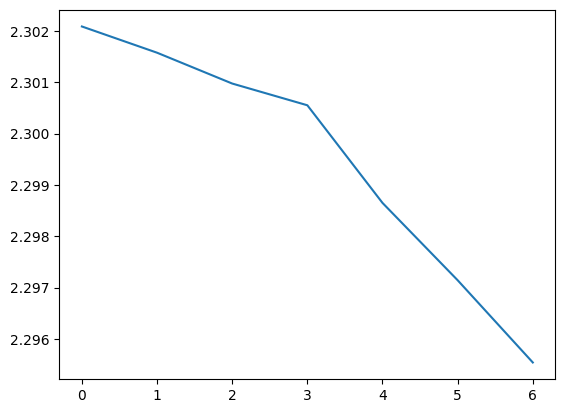

In [8]:
net = VGG7()#torch.load("../Baseline/baseline.pth")

net.to(device)
optimizer = optim.SGD(net.parameters(), lr = 1e-1, weight_decay=0)

logs_interval = 10
epochs = 1
train_losses = []
iteration = 0

b = torch.clone(net.conv1.weight[0])
b1 = torch.clone(net.conv1.weight[1])

net.train()

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        net.conv1.weight[0].grad = torch.zeros_like(net.conv1.weight[0])
        optimizer.step()
        
        iteration = iteration + 1
        if iteration % logs_interval == 0:
            print('Train epoch:{}, batch index:{}, loss:{}'.format(epoch, batch_idx, loss.item()/logs_interval))
            train_losses.append(loss.item())

print(net.conv1.weight[0])
print(b)
print(net.conv1.weight[1])
print(b1)

plt.plot(train_losses)







In [9]:
net = VGG7()#torch.load("../Baseline/baseline.pth")

net.to(device)
print(net.fc3.weight[0].requires_grad)
optimizer = optim.SGD(net.parameters(), lr = 1e-1, weight_decay=0)

# b = torch.clone(net.conv1.weight[0])
# print(b == net.conv1.weight[0])
# b1 = torch.clone(net.conv1.weight[1])

net.train()

data, target = train_data[1]
target = torch.Tensor([target]).long()

data, target = data.to(device), target.to(device)
optimizer.zero_grad()
output = net(data)
loss = F.nll_loss(output, target)
loss.backward()
print(net.conv1.weight[0].grad)
net.conv1.weight[0].grad = torch.zeros_like(net.conv1.weight[0])


# print(b == net.conv1.weight[0])



True
None


C:\Users\win10\AppData\Local\Temp\ipykernel_21640\1025493926.py:21: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:485.)
  print(net.conv1.weight[0].grad)


In [31]:
net=VGG7()
print(net.fc3.weight.size())
net.fc1.weight[:,0]

W=torch.Tensor(np.random.randn(10))*10

values,index=w_sort

values
index

W.view(-1)




torch.Size([10, 256])


tensor([ -6.5783,  16.3643,  -2.1486,   4.3815,  -2.9944,  -6.8572,  11.7657,
         -9.4291, -16.7526,  -8.7819])

In [144]:
w_abs=torch.abs(W)
values_sort,indexes_sort=torch.sort(w_abs,descending=True)


print(indexes_sort)

number=5

T= torch.Tensor(np.zeros_like(W))

print(T)

percentaje=0.5
k=np.floor((len(w_abs)*percentaje)) #cate elem luam in fs de %
print(k)

getindexu=indexes_sort[:int(k)]


for i in range(len(getindexu)):
    T[getindexu[i]]=1

    
print(W,T)



print(values_sort)








tensor([8, 1, 6, 7, 9, 5, 0, 3, 4, 2])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
5.0
tensor([ -6.5783,  16.3643,  -2.1486,   4.3815,  -2.9944,  -6.8572,  11.7657,
         -9.4291, -16.7526,  -8.7819]) tensor([0., 1., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([16.7526, 16.3643, 11.7657,  9.4291,  8.7819,  6.8572,  6.5783,  4.3815,
         2.9944,  2.1486])


In [165]:
T= torch.Tensor(np.zeros_like(W))  #  DE AICI IEI BA

def GetZaMask(In,percentage,T):
    Ax= torch.Tensor(np.zeros_like(W))

    for i in range(len(In)):
    
     Ax[i]=torch.where(T[i]==0,In[i],0)

    w_abs=torch.abs(Ax)
    values_sort,indexes_sort=torch.sort(w_abs,descending=True)

    #k=np.floor((len(w_abs)*percentage)) #cate elem luam in fs de % si de c ati de 1 avem(ce procent am avut anterior)

    count = torch.sum(T == 1)
    
    k=np.floor(len(ex)*perc)-count
    k=int(k)

    if k <0:
      k=0

    sorted_indexes=indexes_sort[:int(k)]

    for i in range(len(sorted_indexes)):
        
        T[sorted_indexes[i]]=1

    return T
    




0
1
2
3
4
tensor([0., 1., 0., 0., 0., 1., 1., 1., 1., 0.])
tensor([8, 1, 6, 7, 9, 5, 0, 3, 4, 2])
tensor([ -6.5783,  16.3643,  -2.1486,   4.3815,  -2.9944,  17.0000,  11.7657,
         -9.4291, -16.7526,  -8.7819])


In [209]:
T

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [205]:
var= torch.Tensor ([2,0,1,5,7,12,3,90,11,4])
T= torch.Tensor(np.zeros_like(var))

GetZaMask(var,0.5,T)




0
1
2
3
4


tensor([0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])

In [208]:
var= torch.Tensor ([3,4,1,5,7,12,2,90,11,0])
GetZaMask(var,1,T)

0
1
2
3
4
5
6
7
8
9


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [181]:
A=torch.Tensor([11,9,3,43,6,22,3,0,89,76])
B=torch.Tensor([1,0,0,0,0,0,0,0,1,1])
Am= torch.Tensor(np.zeros_like(A))
Z= torch.Tensor(np.zeros_like(A))


for i in range(len(B)):
    
    Am[i]=torch.where(B[i]==0,A[i],0)

print(Am)

GetZaMask(Am,0.3,Z)
# t ul ultim se aduna la ala initial

tensor([ 0.,  9.,  3., 43.,  6., 22.,  3.,  0.,  0.,  0.])
0
1
2


tensor([0., 1., 0., 1., 0., 1., 0., 0., 0., 0.])

In [201]:
# nr corect de elem ce trebe facute 1

ex=torch.Tensor([1,0,0,0,0,0,1,1,1,1])
count = torch.sum(ex == 1)
perc=1
elems=np.floor(len(ex)*perc)-count
elems=int(elems)

if elems <0:
    elems=0


print(elems)


5


In [203]:
print(T)

tensor([0., 0., 0., 1., 1., 1., 0., 1., 1., 0.])
